In [1]:
# Imports
import pandas as pd
import datetime as dt

import numpy as np
import tensorflow as tf

import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras import layers, models, regularizers, callbacks
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, f1_score
from imblearn.over_sampling import SMOTE 

In [2]:
def clean_up_observations_and_add_rain_class(atg_obs_selected):
    no_erros_obs = atg_obs_selected.loc[(atg_obs_selected['Rain']!='M')&(atg_obs_selected['Temperature']!='M')&(atg_obs_selected['Pressure']!='M')&(atg_obs_selected['Relhum']!='M')&(atg_obs_selected['Relhum']!='0.00.')].copy()

    no_erros_obs['datetime_PST'] = pd.DatetimeIndex(no_erros_obs['datetime_UTC']).tz_localize('UTC').tz_convert('US/Pacific')
    no_erros_obs['Date_PST'] = pd.DatetimeIndex(no_erros_obs['datetime_PST']).date
    no_erros_obs['Time_PST'] = pd.DatetimeIndex(no_erros_obs['datetime_PST']).time
    no_erros_obs['Rain'] = no_erros_obs['Rain'].astype(float)
    no_erros_obs['Temperature'] = no_erros_obs['Temperature'].astype(float)
    no_erros_obs['Pressure'] = no_erros_obs['Pressure'].astype(float)
    no_erros_obs['Relhum'] = no_erros_obs['Relhum'].astype(float)

    first_obs_each_period = no_erros_obs.resample(on='datetime_PST', rule='1h')
    summed_rain_each_period = first_obs_each_period['Rain'].sum()

    lightrainfall_times = summed_rain_each_period[(summed_rain_each_period<=0.06)&(summed_rain_each_period>0.0)]
    moderaterainfall_times = summed_rain_each_period[(summed_rain_each_period<=0.10)&(summed_rain_each_period>0.06)]
    heavyrainfall_times = summed_rain_each_period[(summed_rain_each_period>0.10)]

    summed_rain_each_period.loc[lightrainfall_times.index] = 1
    summed_rain_each_period.loc[moderaterainfall_times.index] = 2
    summed_rain_each_period.loc[heavyrainfall_times.index] = 3

    # Extract Date, Time, Temperature, SumRain into data array
    atg_obs_necessary = pd.DataFrame()
    atg_obs_necessary['date'] = first_obs_each_period['Date_PST'].first()
    atg_obs_necessary['time'] = first_obs_each_period['Time_PST'].first()
    atg_obs_necessary['temperature'] = first_obs_each_period['Temperature'].first()
    atg_obs_necessary['pressure'] = first_obs_each_period['Pressure'].first()
    atg_obs_necessary['relhum'] = first_obs_each_period['Relhum'].first()
    atg_obs_necessary['rainfall_type'] = summed_rain_each_period

    atg_obs_necessary = atg_obs_necessary.dropna()
    data_arr = atg_obs_necessary.values


    return atg_obs_necessary, data_arr

In [3]:
atg_obs = pd.read_csv('../../Downloads/LFEM_data-.csv', low_memory=False, skiprows=1)
atg_obs.insert(0, 'datetime_UTC', pd.to_datetime(atg_obs['Date'] + atg_obs['Time'], format='%Y-%m-%d%H:%M'))

In [4]:
atg_obs_selected = atg_obs.copy() # Selecting dates
atg_obs_selected = atg_obs_selected.loc[(atg_obs['datetime_UTC']>=dt.datetime(2023,1,1))]

In [5]:
# Extract Date, Time, Temperature, SumRain into data array
atg_obs_necessary, data_arr = clean_up_observations_and_add_rain_class(atg_obs_selected)

In [6]:
atg_obs_necessary.iloc[-100:-60,:]

,date,time,temperature,pressure,relhum,rainfall_type
datetime_PST,,,,,,
2024-05-19 07:00:00-07:00,2024-05-19,07:00:00,48.3,1019.2,88.5,0.0
2024-05-19 08:00:00-07:00,2024-05-19,08:00:00,48.8,1019.6,85.9,0.0
2024-05-19 09:00:00-07:00,2024-05-19,09:00:00,51.4,1020.2,77.0,0.0
2024-05-19 10:00:00-07:00,2024-05-19,10:00:00,52.9,1020.4,71.7,0.0
2024-05-19 11:00:00-07:00,2024-05-19,11:00:00,51.3,1020.7,74.5,0.0
2024-05-19 12:00:00-07:00,2024-05-19,12:00:00,53.4,1020.8,62.8,0.0
2024-05-19 13:00:00-07:00,2024-05-19,13:00:00,56.3,1020.8,58.4,0.0
2024-05-19 14:00:00-07:00,2024-05-19,14:00:00,59.1,1020.4,50.4,0.0
2024-05-19 15:00:00-07:00,2024-05-19,15:00:00,61.4,1020.2,49.6,0.0


In [7]:
atg_obs_necessary[atg_obs_necessary['rainfall_type']==3][-10:]

,date,time,temperature,pressure,relhum,rainfall_type
datetime_PST,,,,,,
2024-03-21 21:00:00-07:00,2024-03-21,21:00:00,52.7,1014.5,89.1,3.0
2024-04-02 22:00:00-07:00,2024-04-02,22:00:00,52.2,1017.0,75.2,3.0
2024-04-02 23:00:00-07:00,2024-04-02,23:00:00,46.2,1017.6,91.6,3.0
2024-04-29 04:00:00-07:00,2024-04-29,04:00:00,43.4,1012.1,90.0,3.0
2024-04-29 17:00:00-07:00,2024-04-29,17:00:00,50.7,1014.3,61.5,3.0
2024-04-29 18:00:00-07:00,2024-04-29,18:00:00,47.9,1014.4,76.0,3.0
2024-05-07 00:00:00-07:00,2024-05-07,00:00:00,46.0,1013.1,91.5,3.0
2024-05-19 04:00:00-07:00,2024-05-19,04:00:00,48.6,1017.7,88.1,3.0
2024-05-22 02:00:00-07:00,2024-05-22,02:00:00,47.1,1006.1,88.4,3.0


In [8]:
def select_times_around_specific_events(atg_obs_necessary, event, num_days_around):
    notable_event_times = atg_obs_necessary.loc[atg_obs_necessary['rainfall_type']>=event].index

    relevant_events = pd.DataFrame()
    for event_time in notable_event_times:
        start_time = event_time-pd.Timedelta(days=num_days_around)
        end_time = event_time+pd.Timedelta(days=num_days_around)
        time_around_event = atg_obs_necessary.loc[start_time:end_time].copy()
        relevant_events = pd.concat([relevant_events, time_around_event]).drop_duplicates()
    
    return relevant_events

In [9]:
relevant_events = select_times_around_specific_events(atg_obs_necessary, 3, 15)
relevant_events

,date,time,temperature,pressure,relhum,rainfall_type
datetime_PST,,,,,,
2022-12-31 16:00:00-08:00,2022-12-31,16:00:00,48.2,1008.5,80.8,0.0
2022-12-31 17:00:00-08:00,2022-12-31,17:00:00,48.5,1009.2,81.2,0.0
2022-12-31 18:00:00-08:00,2022-12-31,18:00:00,47.2,1009.8,89.0,0.0
2022-12-31 19:00:00-08:00,2022-12-31,19:00:00,47.3,1010.2,87.6,0.0
2022-12-31 20:00:00-08:00,2022-12-31,20:00:00,47.0,1011.0,87.9,1.0
...,...,...,...,...,...,...
2024-05-23 06:00:00-07:00,2024-05-23,06:00:00,50.5,1016.5,77.4,0.0
2024-05-23 07:00:00-07:00,2024-05-23,07:00:00,51.7,1016.8,74.0,0.0
2024-05-23 08:00:00-07:00,2024-05-23,08:00:00,52.4,1017.0,69.1,0.0


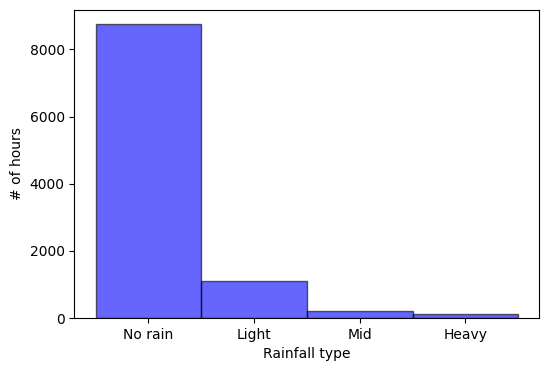

(array([8747, 1109,  188,  102]), array([0., 1., 2., 3., 4.]))

In [10]:
rain_counts, classes = np.histogram(relevant_events['rainfall_type'].values, bins=np.arange(0,relevant_events['rainfall_type'].max()+2))

plt.figure(figsize=(6,4))
plt.bar(x=np.arange(0,relevant_events['rainfall_type'].max()+1), width=1, height=rain_counts, facecolor='blue', edgecolor='k', alpha=0.6)
plt.ylabel('# of hours')
plt.xticks(ticks=np.arange(0,relevant_events['rainfall_type'].max()+1), labels=['No rain', 'Light', 'Mid', 'Heavy'])
plt.xlabel('Rainfall type')
plt.show()
rain_counts, classes

In [11]:
def get_processed_df_from_data(dataset):
    date_objs = pd.to_datetime(dataset['date'], format="%Y-%m-%d")
    time_objs = pd.to_datetime(dataset['time'], format='%H:%M:%S')

    months = pd.DatetimeIndex(date_objs).month
    hours = pd.DatetimeIndex(time_objs).hour

    processed_df = pd.DataFrame()
    # processed_df['months_from_july'] = (np.abs(months - 7))
    # processed_df['time_of_day'] = (((hours-2)%24) // 6).astype(int)

    vals = dataset['temperature']
    processed_df['feature_1'] = vals.values

    vals = dataset['pressure']
    processed_df['feature_3'] = vals.values

    vals = dataset['relhum']
    processed_df['feature_2'] = vals.values
    
    processed_df['class'] = dataset['rainfall_type'].values
    return processed_df

In [12]:
def create_oversampled_df(processed_df):
    num_zeros = processed_df[processed_df['class']==0].shape[0]

    zeros_samps = processed_df[processed_df['class']==0].copy()
    dupl_processed_df = zeros_samps
    for group in np.arange(1, 4):
        under_group_samps = processed_df[processed_df['class']==group].copy()
        group_samps = under_group_samps.sample(n=(num_zeros-len(under_group_samps)), replace=True, random_state=42)
        
        np.random.seed(1)
        noise = np.random.normal(0,1,(num_zeros-len(under_group_samps)))
        group_samps['feature_1'] = group_samps['feature_1']+noise

        np.random.seed(2)
        noise = np.random.normal(0,1,(num_zeros-len(under_group_samps)))
        group_samps['feature_2'] = group_samps['feature_2']+noise

        np.random.seed(3)
        noise = np.random.normal(0,1,(num_zeros-len(under_group_samps)))
        group_samps['feature_3'] = group_samps['feature_3']+noise

        dupl_processed_df = pd.concat([dupl_processed_df, under_group_samps, group_samps])

    return dupl_processed_df

In [13]:
raw_df_train_val, raw_under_df_test = train_test_split(relevant_events,random_state=42,test_size=0.2)
raw_under_df_train, raw_under_df_val = train_test_split(raw_df_train_val,random_state=42,test_size=0.25)

In [14]:
raw_under_df_train = raw_under_df_train.sort_index()
raw_under_df_val = raw_under_df_val.sort_index()
raw_under_df_test = raw_under_df_test.sort_index()

In [15]:
raw_under_df_train

,date,time,temperature,pressure,relhum,rainfall_type
datetime_PST,,,,,,
2022-12-31 17:00:00-08:00,2022-12-31,17:00:00,48.5,1009.2,81.2,0.0
2022-12-31 18:00:00-08:00,2022-12-31,18:00:00,47.2,1009.8,89.0,0.0
2022-12-31 20:00:00-08:00,2022-12-31,20:00:00,47.0,1011.0,87.9,1.0
2022-12-31 21:00:00-08:00,2022-12-31,21:00:00,46.2,1011.7,90.6,0.0
2022-12-31 22:00:00-08:00,2022-12-31,22:00:00,45.9,1012.3,90.5,0.0
...,...,...,...,...,...,...
2024-05-23 05:00:00-07:00,2024-05-23,05:00:00,50.2,1016.3,78.6,0.0
2024-05-23 06:00:00-07:00,2024-05-23,06:00:00,50.5,1016.5,77.4,0.0
2024-05-23 07:00:00-07:00,2024-05-23,07:00:00,51.7,1016.8,74.0,0.0


In [16]:
under_sam_reltimes_tr = get_processed_df_from_data(raw_under_df_train)
processed_df_train = create_oversampled_df(under_sam_reltimes_tr)
under_sam_reltimes_tr

,feature_1,feature_3,feature_2,class
0,48.5,1009.2,81.2,0.0
1,47.2,1009.8,89.0,0.0
2,47.0,1011.0,87.9,1.0
3,46.2,1011.7,90.6,0.0
4,45.9,1012.3,90.5,0.0
...,...,...,...,...
6082,50.2,1016.3,78.6,0.0
6083,50.5,1016.5,77.4,0.0
6084,51.7,1016.8,74.0,0.0
6085,52.4,1017.0,69.1,0.0


In [17]:
processed_df_val = get_processed_df_from_data(raw_under_df_val)
# processed_df_val = create_oversampled_df(under_sam_reltimes_va) 
processed_df_val

,feature_1,feature_3,feature_2,class
0,44.7,1018.0,87.5,0.0
1,43.4,1013.5,88.4,0.0
2,38.2,1004.2,78.1,0.0
3,48.2,1001.1,55.2,0.0
4,46.7,1000.8,55.5,0.0
...,...,...,...,...
2024,45.9,1007.4,88.5,2.0
2025,46.4,1006.8,87.2,0.0
2026,47.4,1007.3,88.0,0.0
2027,60.6,1012.4,49.9,0.0


In [18]:
processed_df_train.shape, processed_df_val.shape

((20968, 4), (2029, 4))

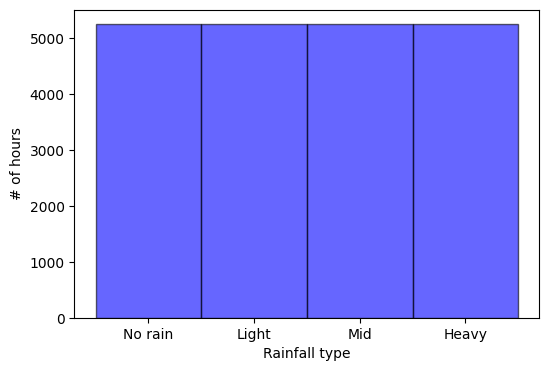

(array([5242, 5242, 5242, 5242]), array([0., 1., 2., 3., 4.]))

In [19]:
rain_counts, classes = np.histogram(processed_df_train['class'].values, bins=np.arange(0,processed_df_train['class'].max()+2))

plt.figure(figsize=(6,4))
plt.bar(x=np.arange(0,processed_df_train['class'].max()+1), width=1, height=rain_counts, facecolor='blue', edgecolor='k', alpha=0.6)
plt.xticks(ticks=np.arange(0,processed_df_train['class'].max()+1), labels=['No rain', 'Light', 'Mid', 'Heavy'])
plt.xlabel('Rainfall type')
plt.ylabel('# of hours')
plt.show()
rain_counts, classes

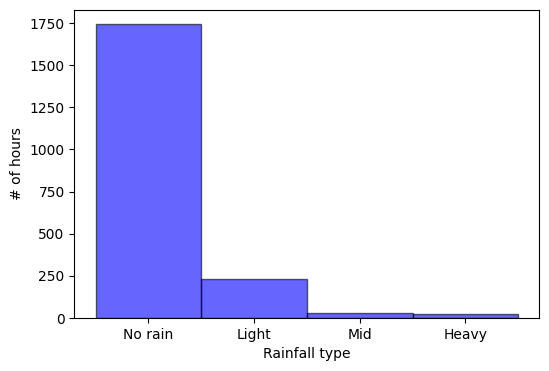

(array([1743,  232,   30,   24]), array([0., 1., 2., 3., 4.]))

In [20]:
rain_counts, classes = np.histogram(processed_df_val['class'].values, bins=np.arange(0,processed_df_train['class'].max()+2))

plt.figure(figsize=(6,4))
plt.bar(x=np.arange(0,processed_df_train['class'].max()+1), width=1, height=rain_counts, facecolor='blue', edgecolor='k', alpha=0.6)
plt.xticks(ticks=np.arange(0,processed_df_train['class'].max()+1), labels=['No rain', 'Light', 'Mid', 'Heavy'])
plt.xlabel('Rainfall type')
plt.ylabel('# of hours')
plt.show()
rain_counts, classes

In [21]:
processed_data_train = processed_df_train.values.astype(float)
processed_data_train.shape

(20968, 4)

In [22]:
processed_data_val = processed_df_val.values.astype(float)
processed_data_val.shape

(2029, 4)

In [23]:
x_data_train = processed_data_train[:, :processed_data_train.shape[1]-1]
y_data_train = processed_data_train[:, processed_data_train.shape[1]-1:].astype(int)
print(x_data_train[0], y_data_train[0])

[  48.5 1009.2   81.2] [0]


In [24]:
x_data_val = processed_data_val[:, :processed_data_train.shape[1]-1]
y_data_val = processed_data_val[:, processed_data_train.shape[1]-1:].astype(int)
print(x_data_val[0], y_data_val[0])

[  44.7 1018.    87.5] [0]


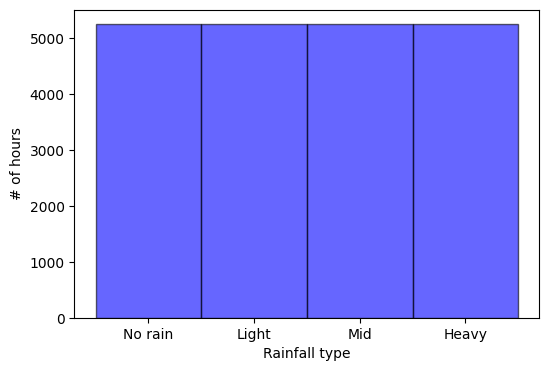

(array([5242, 5242, 5242, 5242]), array([0, 1, 2, 3, 4]))

In [25]:
rain_counts, classes = np.histogram(y_data_train, bins=np.arange(0,y_data_train.max()+2))

plt.figure(figsize=(6,4))
plt.bar(x=np.arange(0,y_data_train.max()+1), width=1, height=rain_counts, facecolor='blue', edgecolor='k', alpha=0.6)
plt.ylabel('# of hours')
plt.xticks(ticks=np.arange(0,y_data_train.max()+1), labels=['No rain', 'Light', 'Mid', 'Heavy'])
plt.xlabel('Rainfall type')
plt.show()
rain_counts, classes

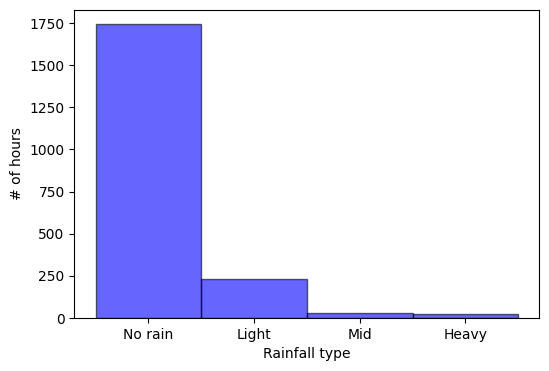

(array([1743,  232,   30,   24]), array([0, 1, 2, 3, 4]))

In [26]:
rain_counts, classes = np.histogram(y_data_val, bins=np.arange(0,y_data_train.max()+2))

plt.figure(figsize=(6,4))
plt.bar(x=np.arange(0,y_data_train.max()+1), width=1, height=rain_counts, facecolor='blue', edgecolor='k', alpha=0.6)
plt.ylabel('# of hours')
plt.xticks(ticks=np.arange(0,y_data_train.max()+1), labels=['No rain', 'Light', 'Mid', 'Heavy'])
plt.xlabel('Rainfall type')
plt.show()
rain_counts, classes

In [27]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(x_data_train)
X_val_scaled = scaler.transform(x_data_val)

# Define the model
model = models.Sequential()

# Input layer
model.add(layers.Input(shape=(x_data_train.shape[1],)))

# Hidden layers
model.add(layers.Dense(128, activation='relu', kernel_regularizer=regularizers.l2(0.001)))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(128, activation='relu', kernel_regularizer=regularizers.l2(0.001)))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(128, activation='relu', kernel_regularizer=regularizers.l2(0.001)))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(64, activation='relu', kernel_regularizer=regularizers.l2(0.001)))
model.add(layers.Dropout(0.5))

# Output layer
model.add(layers.Dense(4, activation='softmax'))  # Softmax for multiclass classification

# Compile the model
optimizer = Adam(learning_rate=0.001)
model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Learning rate reduction callback
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.0001)

# Early stopping callback
early_stopping = callbacks.EarlyStopping(monitor='val_loss', patience=40, restore_best_weights=True)

# Print model summary
model.summary()

Metal device set to: Apple M2

systemMemory: 16.00 GB
maxCacheSize: 5.33 GB



2024-05-26 23:10:01.435093: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-05-26 23:10:01.436932: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 128)               512       
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 128)               16512     
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_2 (Dense)             (None, 128)               16512     
                                                                 
 dropout_2 (Dropout)         (None, 128)               0         
                                                                 
 dense_3 (Dense)             (None, 64)                8

In [28]:
X_train_scaled.shape, y_data_train.shape

((20968, 3), (20968, 1))

In [29]:
X_val_scaled.shape, y_data_val.shape

((2029, 3), (2029, 1))

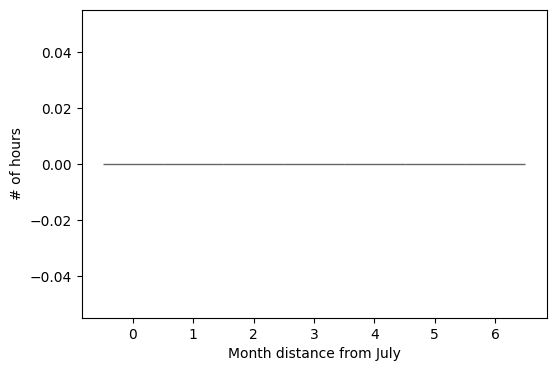

(array([0, 0, 0, 0, 0, 0, 0]), array([0, 1, 2, 3, 4, 5, 6, 7]))

In [30]:
binwidth = 1
rain_counts, classes = np.histogram(x_data_train[:,0], bins=np.arange(0,7+binwidth,binwidth))

plt.figure(figsize=(6,4))
plt.bar(x=np.arange(0,7,binwidth), width=binwidth, height=rain_counts, facecolor='blue', edgecolor='k', alpha=0.6)
plt.ylabel('# of hours')
plt.xlabel('Month distance from July')
plt.show()
rain_counts, classes

In [31]:
X_train_scaled

array([[-0.09726985,  0.11850265, -0.16196919],
       [-0.27865132,  0.19443699,  0.41270572],
       [-0.41817554,  0.43489574,  0.53058775],
       ...,
       [ 0.72975141, -1.81978078,  0.77727795],
       [ 0.90729696, -1.77843801,  0.6429624 ],
       [-0.05495302, -0.23304737,  0.82459174]])

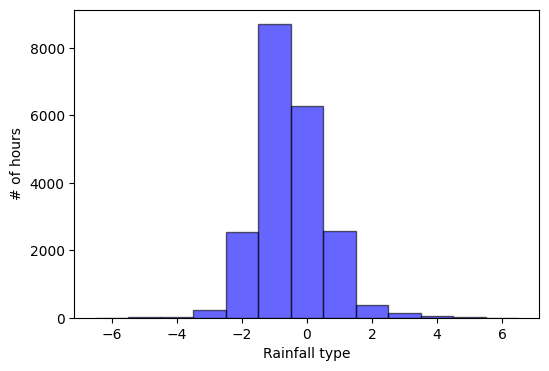

(array([   0,   16,   28,  243, 2539, 8696, 6277, 2579,  378,  146,   53,
          13,    0]),
 array([-6, -5, -4, -3, -2, -1,  0,  1,  2,  3,  4,  5,  6,  7]))

In [32]:
binwidth = 1
rain_counts, classes = np.histogram(X_train_scaled[:,0], bins=np.arange(-6,7+binwidth,binwidth))

plt.figure(figsize=(6,4))
plt.bar(x=np.arange(-6,7,binwidth), width=binwidth, height=rain_counts, facecolor='blue', edgecolor='k', alpha=0.6)
plt.ylabel('# of hours')
plt.xlabel('Rainfall type')
plt.show()
rain_counts, classes

In [33]:
# Train the Model:
history = model.fit(
    X_train_scaled, y_data_train,
    epochs=60,
    batch_size=32,
    validation_data=(X_val_scaled, y_data_val),
    callbacks=[early_stopping, reduce_lr]
)

Epoch 1/60


2024-05-26 23:10:02.341952: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2024-05-26 23:10:02.846880: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


656/656 [==============================] - ETA: 0s - loss: 1.4169 - accuracy: 0.4208

2024-05-26 23:10:15.727808: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


656/656 [==============================] - 14s 20ms/step - loss: 1.4169 - accuracy: 0.4208 - val_loss: 1.1233 - val_accuracy: 0.6890 - lr: 0.0010
Epoch 2/60
656/656 [==============================] - 12s 19ms/step - loss: 1.2600 - accuracy: 0.4389 - val_loss: 1.0842 - val_accuracy: 0.6565 - lr: 0.0010
Epoch 3/60
656/656 [==============================] - 8s 12ms/step - loss: 1.2067 - accuracy: 0.4447 - val_loss: 1.0415 - val_accuracy: 0.6437 - lr: 0.0010
Epoch 4/60
656/656 [==============================] - 7s 11ms/step - loss: 1.1831 - accuracy: 0.4562 - val_loss: 1.1607 - val_accuracy: 0.6190 - lr: 0.0010
Epoch 5/60
656/656 [==============================] - 7s 11ms/step - loss: 1.1666 - accuracy: 0.4633 - val_loss: 1.0185 - val_accuracy: 0.6703 - lr: 0.0010
Epoch 6/60
656/656 [==============================] - 8s 11ms/step - loss: 1.1579 - accuracy: 0.4673 - val_loss: 0.9886 - val_accuracy: 0.6831 - lr: 0.0010
Epoch 7/60
656/656 [==============================] - 7s 11ms/step - loss

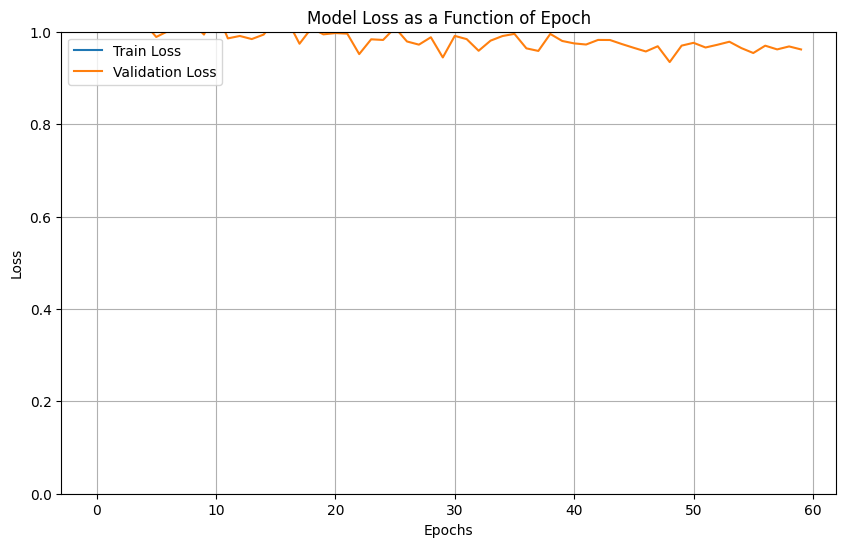

In [34]:
train_loss = history.history['loss']
val_loss = history.history['val_loss']

# Plot the accuracy
plt.figure(figsize=(10, 6))
plt.plot(train_loss, label='Train Loss')
plt.plot(val_loss, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.ylim(0, 1)
plt.title('Model Loss as a Function of Epoch')
plt.legend()
plt.grid(True)
plt.show()

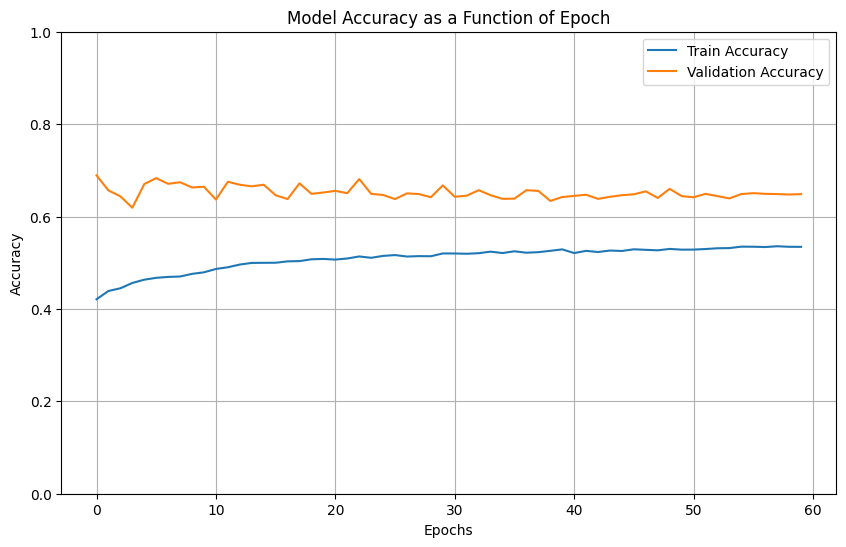

In [35]:
train_accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']

# Plot the accuracy
plt.figure(figsize=(10, 6))
plt.plot(train_accuracy, label='Train Accuracy')
plt.plot(val_accuracy, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.ylim(0, 1)
plt.title('Model Accuracy as a Function of Epoch')
plt.legend()
plt.grid(True)
plt.show()

In [36]:
# Evaluation (Is it worth, the loss is quite high suggesting that either the model architecture is quite poor (likely) or 
# that we need to better preprocess our data such as rain (also likely))

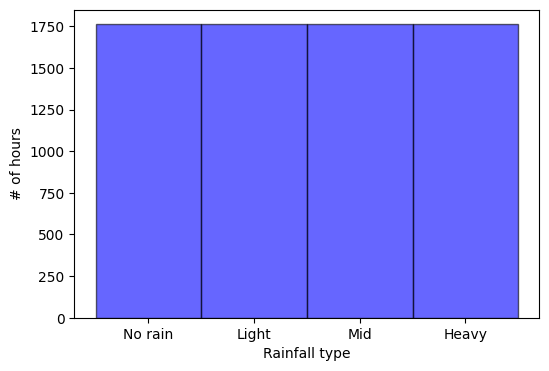

[1762 1762 1762 1762] [0. 1. 2. 3. 4.]
[  48.2 1008.5   80.8] [0]


In [37]:
under_sam_reltimes_te = get_processed_df_from_data(raw_under_df_test)
processed_df_test = create_oversampled_df(under_sam_reltimes_te)

rain_counts, classes = np.histogram(processed_df_test['class'].values, bins=np.arange(0,processed_df_train['class'].max()+2))

plt.figure(figsize=(6,4))
plt.bar(x=np.arange(0,processed_df_train['class'].max()+1), width=1, height=rain_counts, facecolor='blue', edgecolor='k', alpha=0.6)
plt.xticks(ticks=np.arange(0,processed_df_train['class'].max()+1), labels=['No rain', 'Light', 'Mid', 'Heavy'])
plt.xlabel('Rainfall type')
plt.ylabel('# of hours')
plt.show()
print(rain_counts, classes)

processed_data_test = processed_df_test.values.astype(float)
x_data_test = processed_data_test[:, :processed_data_test.shape[1]-1]
y_data_test = processed_data_test[:, processed_data_test.shape[1]-1:].astype(int)
print(x_data_test[0], y_data_test[0])

In [38]:
X_test_scaled = scaler.transform(x_data_test)
predictions = model.predict(X_test_scaled)
model.evaluate(X_test_scaled, y_data_test.ravel().astype(float), verbose=2)

 19/221 [=>............................] - ETA: 0s 

2024-05-26 23:17:42.430009: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


221/221 [==============================] - 1s 3ms/step


2024-05-26 23:17:43.253481: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


221/221 - 2s - loss: 1.2476 - accuracy: 0.4428 - 2s/epoch - 7ms/step


[1.2476458549499512, 0.44282066822052]

Confusion Matrix:
[[1231  335  147   49]
 [ 294  622  578  268]
 [ 203  489  716  354]
 [ 114  329  767  552]]


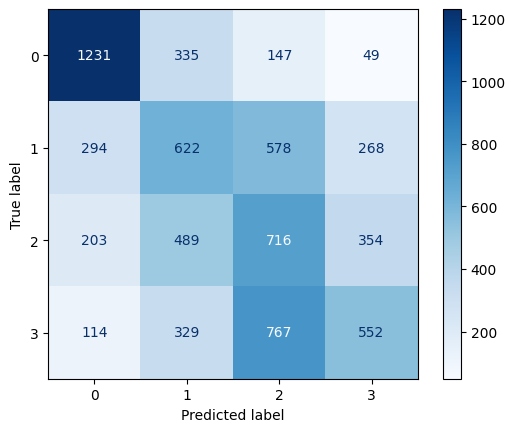

In [39]:
cm = confusion_matrix(y_data_test.ravel(), np.argmax(predictions,axis=1))

# Print the confusion matrix
print("Confusion Matrix:")
print(cm)

# Visualize the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0, 1, 2, 3])
disp.plot(cmap=plt.cm.Blues)
plt.show()

Confusion Matrix:
[[1231  335  147   49]
 [ 294  622  578  268]
 [ 203  489  716  354]
 [ 114  329  767  552]]


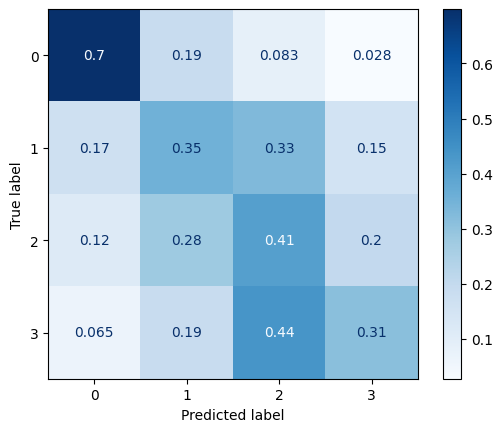

In [40]:
cm = confusion_matrix(y_data_test.ravel(), np.argmax(predictions,axis=1))

# Print the confusion matrix
print("Confusion Matrix:")
print(cm)

# Visualize the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=(cm / np.sum(cm, axis=1).reshape(4, 1)), display_labels=[0, 1, 2, 3])
disp.plot(cmap=plt.cm.Blues)
plt.show()

In [41]:
f1_score(y_data_test.ravel(), np.argmax(predictions,axis=1), average=None)

array([0.68312986, 0.35171049, 0.36070529, 0.36984925])